In [81]:
import os.path as osp
import numpy as np
import pickle
import copy

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch import optim

import carla_visual as cv
from carla_visual.dataloaders.online_dataset import load_online_dataset, build_dataloader

from carla_visual.models.classifiers import PIECECNN
from carla_visual.models.generators import PIECEGenerator

from carla_visual.models.utils import fetch_weights, load_model_weights
import carla_visual.evaluation.evaluate_prediction_model as epm

from carla_visual.recourse_methods.piece import get_misclassifications, get_misclassificaiton, return_feature_contribution_data
from carla_visual.recourse_methods.piece import acquire_feature_probabilities, filter_df_of_exceptional_noise, optimize_z0, modifying_exceptional_features
from carla_visual.plotting.plot_output import plot_misclassifications

from carla_visual.plotting.plot_output import plot_image 

# Prepare data

In [2]:
ds_name = 'MNIST'
data_root = 'D:\PycharmProjects\XAIRobustness\data\images'

train_data, test_data = load_online_dataset(ds_name, data_root, download=False, split_val=False)
print(f'Shape of the train set: ', train_data.data.shape)
print(f'Shape of the test set: ', test_data.data.shape)

Shape of the train set:  torch.Size([60000, 28, 28])
Shape of the test set:  torch.Size([10000, 28, 28])


In [3]:
input_chn = 1
num_classes = 10
batch_size = 1
nz = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ngpu = 0 if device == 'cpu' else 1


In [4]:
train_dataloader, test_dataloader = build_dataloader([train_data, test_data], 
                                                      batch_size=batch_size, 
                                                      shuffle=True)

# Load pre-trained CNN and Generator 

In [5]:
original_cnn_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/pytorch_cnn.pth'
original_gen_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/generator.pth'

output_dir = 'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\piece'
cnn_weights_file = 'cnn_weights.pth'
gen_weights_file = 'generator_weights.pth'


In [6]:
fetch_weights(original_cnn_weights, file_name=cnn_weights_file, output_dir=output_dir)
fetch_weights(original_gen_weights, file_name=gen_weights_file, output_dir=output_dir)

In [6]:
cnn = PIECECNN(input_chn, num_classes)
print('Total number of parameters in the CNN:', cnn.get_params_num())
cnn = load_model_weights(cnn, osp.join(output_dir, cnn_weights_file), device=device)


Total number of parameters in the CNN: 143162


In [8]:
print('Accuracy of the pre-trained CNN: ', epm.evaluate_model(cnn, test_dataloader, device)['accuracy'])

Evaluating: 100%|██████████| 10000/10000 [00:35<00:00, 282.12it/s]

Accuracy of the pre-trained CNN:  0.9932


In [7]:
gen = PIECEGenerator(ngpu=ngpu)
gen = load_model_weights(gen, osp.join(output_dir, gen_weights_file), device=device)

Check the generative performance of the loaded generator 

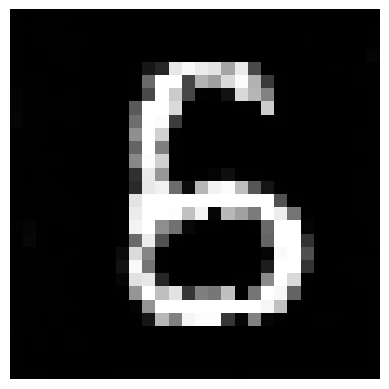

In [10]:
z = torch.randn(batch_size, nz)
z = z.view(z.size(0), nz, 1, 1)
generated_images = gen(z)
plot_image(generated_images) 

# PIECE Algorithm  #

1) Obtaining a misclassified instance with the specified index *k_misclf_num* 

In [93]:
original_query_idx, original_query_img, \
original_query_label, original_query_prediction = get_misclassificaiton(test_dataloader, cnn, k_misclf_num=2)

Label: 6
Prediction: 4


Visualize several missclassifications found in the whole test set 

In [9]:
misclf_samples = get_misclassifications(cnn, test_dataloader, device)

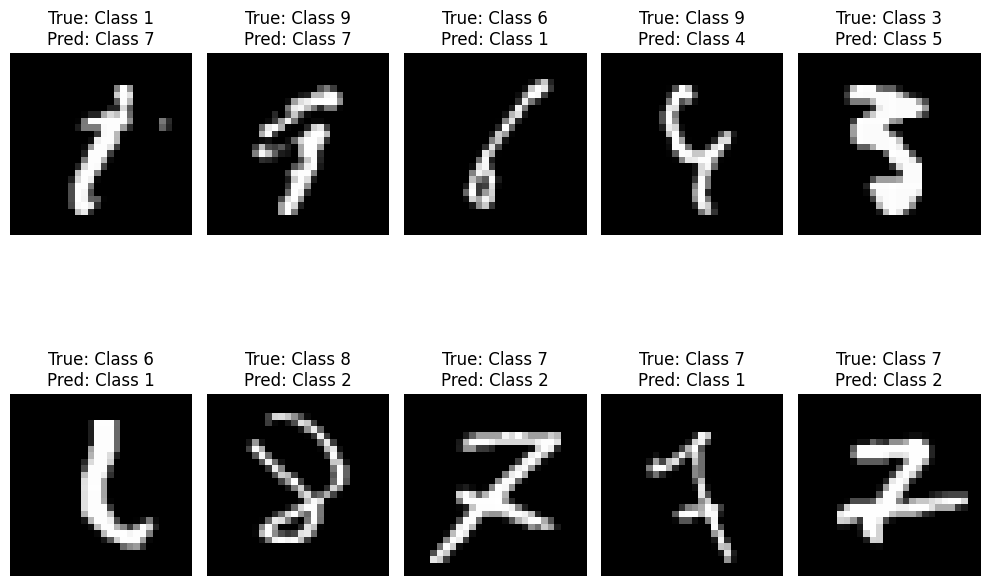

In [10]:
plot_misclassifications(misclf_samples)

2) Identifying the latent vector that corresponds to the given misclassified image

In [94]:
z_I = optimize_z0(gen, cnn.main, original_query_img, nz)

Iteration 0, Loss: 4522.54443359375
Iteration 100, Loss: 2999.1806640625
Iteration 200, Loss: 2424.129150390625
Iteration 300, Loss: 2015.048828125
Iteration 400, Loss: 1651.19091796875
Iteration 500, Loss: 1633.332275390625
Iteration 600, Loss: 1536.90185546875
Iteration 700, Loss: 1233.998779296875
Iteration 800, Loss: 1133.0162353515625
Iteration 900, Loss: 897.6160278320312
Iteration 1000, Loss: 864.7064208984375
Iteration 1100, Loss: 846.9547119140625
Iteration 1200, Loss: 840.355224609375
Iteration 1300, Loss: 835.583251953125
Iteration 1400, Loss: 833.36865234375
Iteration 1500, Loss: 831.9500732421875
Iteration 1600, Loss: 827.4559326171875
Iteration 1700, Loss: 822.6453247070312
Iteration 1800, Loss: 820.02392578125
Iteration 1900, Loss: 816.7391357421875
Iteration 2000, Loss: 816.1718139648438
Iteration 2100, Loss: 810.5718994140625
Iteration 2200, Loss: 808.431884765625
Iteration 2300, Loss: 800.4140625
Iteration 2400, Loss: 795.2857055664062
Iteration 2500, Loss: 790.151611

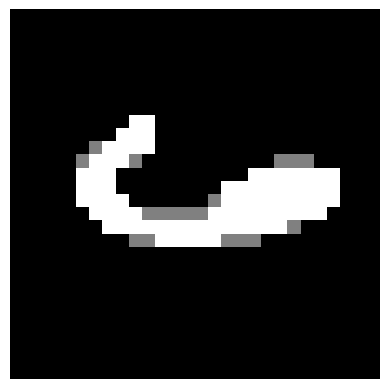

In [95]:
plot_image(original_query_img)

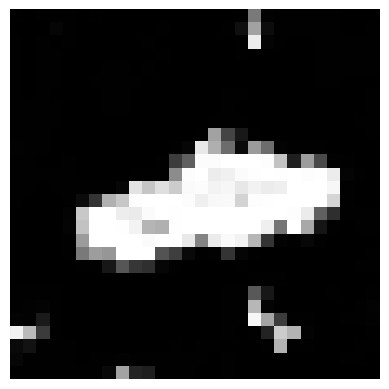

In [96]:
plot_image(gen(z_I))

In [98]:
query_activations = cnn(gen(z_I))[1][0]

3) Constructing a latent dataset for training data (THE FUNCTION IS TIME-CONSUMING!)

In [13]:
# On this step, we construct a latent datset that constitute the logits of the all training data and the corresponding for them predictions 

latent_ds = return_feature_contribution_data(train_dataloader, cnn, num_classes=10)

0.0 % complete...
17.0 % complete...
33.0 % complete...
50.0 % complete...
67.0 % complete...
83.0 % complete...


(!) Pickle calculated activations and their corresponding predictions

In [21]:
latent_ds_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\latent_ds.pickle'
with open(latent_ds_path, 'wb') as handle:
    pickle.dump(latent_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

(!) Load pre-calculated latent dataset 

In [99]:
latent_ds_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\latent_mnist_dataset.pickle'
with open(latent_ds_path, 'rb') as handle:
    latent_ds = pickle.load(handle)

4) Step 1: Acquire the probability of each features, and identify the excpetional ones (i.e., those with a probability lower than alpha)

In [100]:
alpha = 0.05

In [101]:
df = acquire_feature_probabilities(latent_ds, original_query_label, cnn, original_query_img, alpha)

In [102]:
df

,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type
0,0,-0.0557,False,False,True,False,0.0462,0.0000,0.0000,gamma
1,1,0.1373,False,False,False,True,0.7364,0.0186,0.2368,norm
2,2,0.0385,False,False,False,True,0.4627,0.0032,0.0872,gamma
3,3,0.0019,False,False,False,False,0.1483,0.4011,0.3607,gamma
4,4,0.0622,False,False,False,True,0.4831,0.0227,0.2617,gamma
...,...,...,...,...,...,...,...,...,...,...
123,123,-0.0806,False,False,True,False,0.0589,0.0001,0.1330,gamma
124,124,-0.0427,False,False,True,False,0.0727,0.0100,0.0000,gamma With Fixed 0 Location
125,125,-0.0472,False,False,True,False,0.0536,0.0000,0.0000,gamma With Fixed 0 Location
126,126,0.1632,False,False,False,False,0.6146,0.3484,0.0271,gamma


5) Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class

In [105]:
df_new

,Feature Map,Contribution,Bern Fail,Bern Success,Cont High,Cont Low,Expected Value,Probability of Event,Distribtuion p-value KsTest,Dist Type,flag
0,0,-0.0557,False,False,True,False,0.0462,0.0000,0.0000,gamma,0
1,1,0.1373,False,False,False,True,0.7364,0.0186,0.2368,norm,0
2,2,0.0385,False,False,False,True,0.4627,0.0032,0.0872,gamma,0
4,4,0.0622,False,False,False,True,0.4831,0.0227,0.2617,gamma,0
5,5,-0.0602,False,False,True,False,0.0685,0.0006,0.0000,gamma With Fixed 0 Location,0
...,...,...,...,...,...,...,...,...,...,...,...
119,119,-0.1318,False,False,True,False,0.0330,0.0000,0.0000,gamma With Fixed 0 Location,0
121,121,-0.1326,False,False,True,False,0.0450,0.0000,0.0152,gamma,0
123,123,-0.0806,False,False,True,False,0.0589,0.0001,0.1330,gamma,0
124,124,-0.0427,False,False,True,False,0.0727,0.0100,0.0000,gamma With Fixed 0 Location,0


In [106]:
df_copy = copy.deepcopy(df)
df_new = df_copy[df_copy['Probability of Event'] < alpha]

df_new['flag'] = 0
digit_weights = cnn.classifier[0].weight[original_query_label]

for idx, row in df_new.iterrows():
    feature_idx = int(row['Feature Map'])  

    if row['Bern Fail']:  # if it's unusual to not activate, but it's negative
        if digit_weights[feature_idx] < 0: 
            df_new.at[feature_idx, 'flag'] = 1
    if row['Cont High']:  # if it's high, but positive
        if digit_weights[feature_idx] > 0: 
            df_new.at[feature_idx, 'flag'] = 1
    if row['Cont Low'] :  # if it's low, but negative
        if digit_weights[feature_idx] < 0: 
            df_new.at[feature_idx, 'flag'] = 1

exceptional_noise_idx = df_new[df_new.flag == 0].index.tolist()
print('Exceptions(?): ', df_new[df_new.flag == 1].index.tolist())
df_copy = df_copy.drop(index=exceptional_noise_idx, axis=0)
print('The length of the latent datset before and after filtering:', df.shape, '|', df_copy.shape)
print('Number of noisy exceptional features deleted:', len(exceptional_noise_idx))


Exceptions(?):  [36, 53, 61, 70, 94, 98, 118]
The length of the latent datset before and after filtering: (128, 10) | (56, 10)
Number of noisy exceptional features deleted: 72


C:\Users\sahat\AppData\Local\Temp\ipykernel_37440\1343122470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


In [108]:
# Sort by least probable to the most probable
df_copy = df_copy.sort_values('Probability of Event')

# Get x' -- The Ideal Explanation
ideal_xprime = modifying_exceptional_features(df_copy, original_query_label, query_activations)   
ideal_xprime = ideal_xprime.clone().detach().float().requires_grad_(False)

In [109]:
def optim_PIECE(G, cnn, x_prime, z_e, criterion, optimizer):
	"""
	Step 3 of the PIECE algorithm
	returns: z prime
	"""

	for i in range(300):

		optimizer.zero_grad()
		logits, x_e = cnn(G(z_e))
		loss = criterion(x_e[0], x_prime)

		loss.backward()  
		optimizer.step()  

		if i % 50 == 0:
			print("Loss:", loss.item())

	return z_e

In [110]:
criterion = nn.MSELoss()
optimizer = optim.Adam([z_I], lr=0.001)
z_prime = optim_PIECE(gen, cnn, ideal_xprime, z_I, criterion, optimizer)

Loss: 0.013176127336919308
Loss: 0.01156739890575409
Loss: 0.01121441274881363
Loss: 0.010827381163835526
Loss: 0.01050705835223198
Loss: 0.01024685800075531


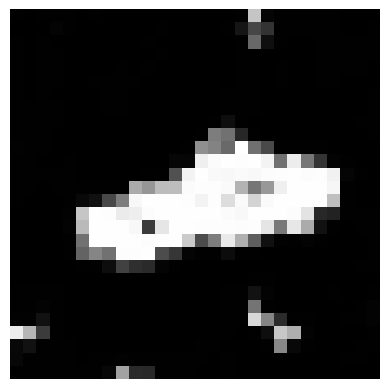

Prediction of the CNN classifier: 6


In [111]:
counterfactual_image = gen(z_prime)
plot_image(counterfactual_image)
print('Prediction of the CNN classifier:', torch.argmax(cnn(counterfactual_image)[0]).numpy())